In [81]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [82]:
""" IMPORTING DATA """

def import_data(file_name):
    data = []
    label = []
    with open(file_name, 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        # skip first row because it has labels
        next(csvreader)
        data_indices = [1,2,3,4,5,7,8,9,10]
        class_index = 6

        for row in csvreader:
            data.append([row[i] for i in data_indices])
            label.append(row[class_index])

    # Convert the list to a numpy array
    data_array = np.array(data)

    # add bias
    bias = np.ones((len(data_array), 1))
    data_array = np.hstack((bias, data_array))

    data_array = data_array.astype(np.float32)
    label_array = np.array(label)
    label_array = label_array.astype(np.float32)
    print(f'label shape: {label_array.shape}')

    # here, we're setting the label to be 1 if a positive quantity is in label, otherwise it's -1
    label_array = np.where(label_array > 0.01, 1, -1)
    label_array = np.reshape(label_array, (len(label_array), 1))

    print(f'label statistics: class -1 {np.sum(label_array == -1)}, class 1 {np.sum(label_array == 1)}')

    # splitting testing data from training data
    num_test = int(len(data_array)/8)
    test_indices = np.random.choice(len(data_array), num_test, replace=False)
    Xtest = data_array[test_indices, :]
    Ytest = label_array[test_indices, :]

    X = np.delete(data_array, test_indices, axis=0)
    Y = np.delete(label_array, test_indices, axis=0)

    return X, Y, Xtest, Ytest

In [83]:
class NeuralNetwork():

    def __init__(self, layer_sizes):
        self.weights = []

        # initializing weights to small random values
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i - 1]) * 0.1)
    
    def tanh(self, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.power(np.tanh(x), 2)

    def output_func(self, X):
        return np.sign(X)
    
    # returns the final classification result
    def predict(self, X):
        A_0 = X.T
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        A_2 = self.output_func(A_2.T)
        return A_2
    
    # returns full history of forward so we can perform backpropagation
    def forward(self, X):
        A_0 = X
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        return (A_0, A_1, A_2)
    
    def backward(self, X, Y):
        A_0 = X
        A_0 = A_0.reshape((len(A_0), 1))

        # forward propagation
        A_0, A_1, A_2 = self.forward(A_0)

        # backward: error of output layer
        dA_2 = A_2 - Y

        # backward: compute weight gradient of layers
        dW_1 = dA_2 @ A_1.T
        dA_1 = self.weights[1].T @ dA_2 * self.d_tanh(A_1)
        dW_0 = dA_1 @ A_0.T

        # final gradient
        weight_gradients = [dW_0, dW_1]
        return weight_gradients

    
    def train(self, X, Y, total_epoch, learning_rate=0.03, learning_rate_decay=0.8):
        print("beginning training")
        accuracy_history = np.zeros((total_epoch,))
        for epoch in range(total_epoch):

            # variable learning rate adjustment
            # TODO: better decay algorithm, such as checking error slope
            if epoch % (total_epoch // 10) == 0:
                learning_rate *= learning_rate_decay
                print(f"epoch {epoch} with learning rate {np.around(learning_rate, 4)}")

            for i in range(0, len(X)):

                weight_gradients = self.backward(X[i], Y[i])
                # subtract the gradient from the weights
                for j in range(len(self.weights)):
                    self.weights[j] -= learning_rate * weight_gradients[j]

            accuracy = self.test(X, Y)
            accuracy_history[epoch] = accuracy
            if epoch % (total_epoch // 10) == 0:
                print(f'training accuracy: {np.around(accuracy, 5)}')
        
        return accuracy_history
            

    def test(self, X, Y):
        results = self.predict(X)
        num_incorrect = np.sum(np.abs(0.5 * (Y - results)))
        accuracy = 1 - (num_incorrect/len(X))
        return accuracy

    def correct(self, x, ans):
        return np.sign(x) == np.sign(ans)

label shape: (3654,)
label statistics: class -1 2079, class 1 1575
beginning training
epoch 0 with learning rate 0.0075
training accuracy: 0.70794
epoch 100 with learning rate 0.0056
training accuracy: 0.73358
epoch 200 with learning rate 0.0042
training accuracy: 0.73546
epoch 300 with learning rate 0.0032
training accuracy: 0.73984
epoch 400 with learning rate 0.0024
training accuracy: 0.7389
epoch 500 with learning rate 0.0018
training accuracy: 0.74328
epoch 600 with learning rate 0.0013
training accuracy: 0.7464
epoch 700 with learning rate 0.001
training accuracy: 0.74672
epoch 800 with learning rate 0.0008
training accuracy: 0.74734
epoch 900 with learning rate 0.0006
training accuracy: 0.75078


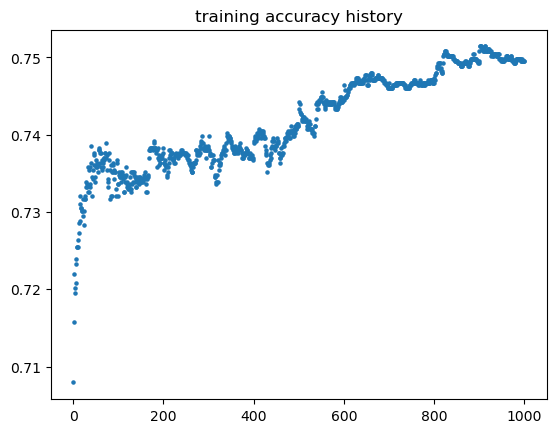

TESTING ACCURACY: 0.7719298245614035


In [84]:
"""TESTING"""

def run():
    file = '../../Data/weather/weather_prediction_dataset.csv'
    X, Y, testX, testY = import_data(file)

    network1 = NeuralNetwork([10, 20, 1])
    total_epoch = 1000
    error_graph = network1.train(X, Y, total_epoch, 0.01, 0.75)

    # plotting training accuracy
    plt.scatter(np.linspace(0, total_epoch, len(error_graph)), error_graph, s=5)
    plt.title("training accuracy history")
    plt.show()

    accuracy = network1.test(testX, testY)
    print(f"TESTING ACCURACY: {accuracy}")

run()